In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import numpy as np
import IPython
from scipy.io import wavfile
from run_duet import duet_ica
from sklearn.decomposition import FastICA
from scipy import signal
from scipy.fftpack import fft
import matplotlib.pylab as plt
import pandas as pd

### Stereo data

In [13]:
fname = 'data/library_alex_george.wav'

rate, x = wavfile.read(fname)
print(x.shape, rate)

(1109376, 2) 44100


<IPython.core.display.Javascript object>


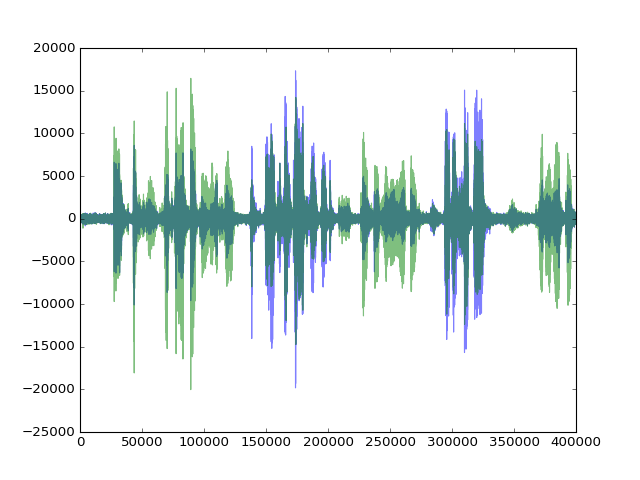

In [18]:
N1 = 0
N2 = 400000
plt.clf()
plt.plot(x[N1:N2, 0], alpha=0.5)
plt.plot(x[N1:N2, 1], alpha=0.5)

<IPython.core.display.Javascript object>


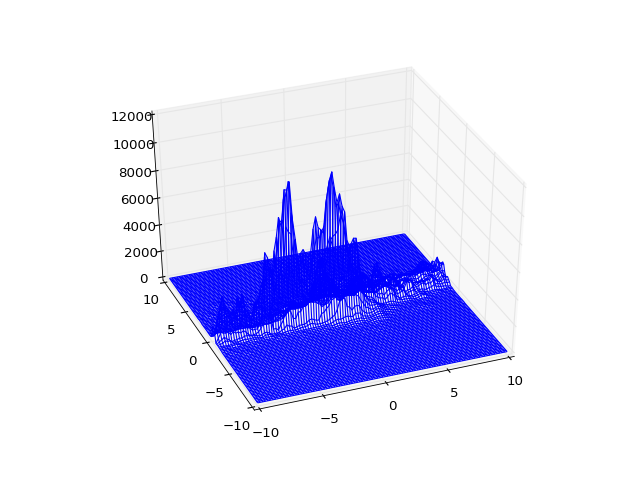

In [6]:
n = 1
s1, s2 = duet_ica(x[:, 0], x[:, 1], 1024*n, 512*n, 1024*n,
                  peakdelta = np.array([-3.7, -0.5]),
                  peakalpha = np.array([-0.7, -0.7]),)

In [10]:
import soundfile as sd
sd.play(s1[N1:N2], samplingrate=rate)

AttributeError: module 'soundfile' has no attribute 'play'

<IPython.core.display.Javascript object>


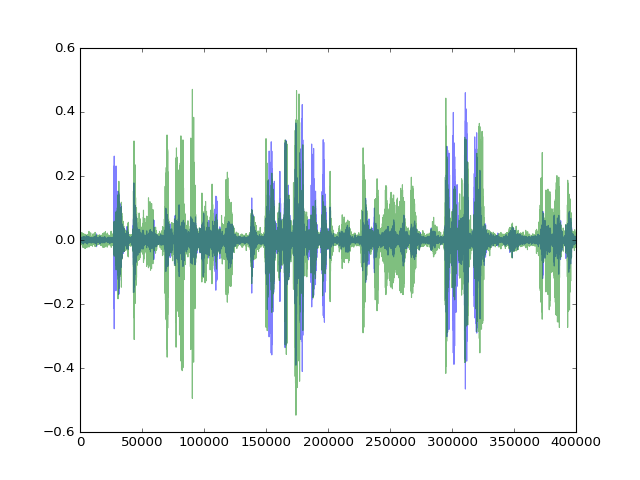

In [31]:
plt.plot(s1[N1:N2], alpha=0.5)
plt.plot(s2[N1:N2], alpha=0.5)

In [5]:
x = x.astype('float32')
s1 = x[:, 0]
s2 = x[:, 1]

In [32]:
from scipy.ndimage.filters import gaussian_filter1d, uniform_filter1d

sp1_e = uniform_filter1d(np.square(s1), rate)
sp2_e = uniform_filter1d(np.square(s2), rate)

In [33]:
eps = np.percentile(sp1_e, 20)
eps

0.00024991471085409413

<IPython.core.display.Javascript object>


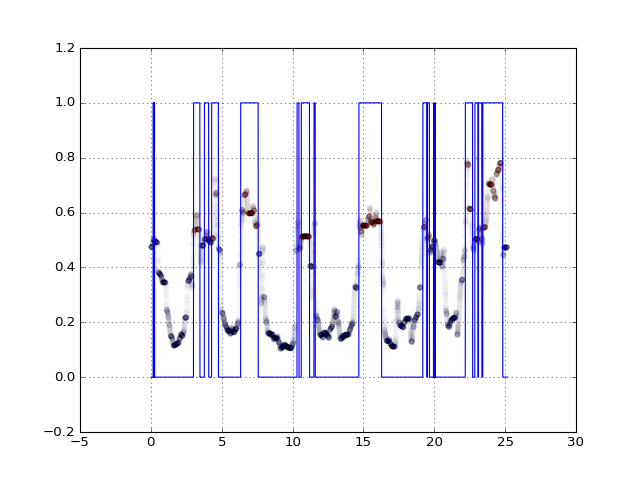

In [34]:
pp0 = (sp1_e + eps) / (sp1_e + sp2_e + 2*eps)

pp = pp0[::100]
t = np.arange(pp.shape[0])/(rate/100)
plt.scatter(t, pp, c=pp>.5, alpha=.01)
plt.plot(t, pp>.5)
plt.grid()
plt.show()

In [35]:
def pp2chunks(pp0):
    chunks = []
    t0 = 0
    for t1 in range(1, pp0.shape[0]):
        if (pp0[t1] > 0.5) ^ (pp0[t0] > 0.5):
            # sign differs
            chunks.append([t0,t1, int(pp0[t0] > .5)])
            t0 = t1
        else:
            pass
    chunks.append([t0,pp0.shape[0], int(pp0[t0] > .5)])
    return chunks

In [36]:
def glue_chunks(chunks):
    big_len = 1. * rate
    min_len = .5 * rate
    i = 0
    while i < len(chunks):
        l1 = chunks[i][1] - chunks[i][0]
        if l1 < min_len:
            l0 = 0
            if i > 0:
                l0 = chunks[i-1][1] - chunks[i-1][0]
            l2 = 0
            if i + 1 < len(chunks):
                l2 = chunks[i+1][1] - chunks[i+1][0]
            if l0 > l2 and l2 > 0 and l0 + l2 > big_len:
                chunks[i-1][1] = chunks[i+1][1]
                chunks.pop(i)
                chunks.pop(i)
            else:
                i += 1
        else:
            i += 1
    return chunks

In [37]:
chunks = pp2chunks(pp0)
chunks2 = glue_chunks(chunks)

In [38]:
markup = pd.read_csv('data/library_alex_george.wav.txt', sep='\t', header=None)

In [39]:
def markup2chunks(markup, rate):
    chunks = []
    for _id,row in markup.iterrows():
        chunks.append([int(row[0] * rate), int(row[1] * rate), row[2]])
    return chunks

In [40]:
chunks_markup = markup2chunks(markup, rate)

In [41]:
def chunks_intersection(a_vec, b_vec):
    i = 0
    j = 0
    stat = {}
    while i < len(a_vec) and j < len(b_vec):
        if a_vec[i][1] <= b_vec[j][0]:
            i += 1
            continue
        if a_vec[i][0] >= b_vec[j][1]:
            j += 1
            continue
        
        key = (a_vec[i][2], b_vec[j][2])
        body = min(a_vec[i][1], b_vec[j][1]) - max(a_vec[i][0], b_vec[j][0])
        stat[key] = stat.get(key, 0) + body
        if a_vec[i][1] < b_vec[j][1]:
            i += 1
        else:
            j += 1
    return stat

In [42]:
intersection_stat = chunks_intersection(chunks2, chunks_markup)

In [43]:
def max_acc(stat):
    a_keys = list(set([a for a,b in stat.keys()]))
    b_keys = list(set([b for a,b in stat.keys()]))
    assert len(a_keys) == 2
    assert len(b_keys) == 2
    
    m = np.zeros((len(a_keys), len(b_keys)))
    for (a,b), cnt in stat.items():
        m[a_keys.index(a), b_keys.index(b)] += cnt
    
    acc = m.trace() / m.sum() 
    return max(acc, 1 - acc)

In [44]:
max_acc(intersection_stat)

0.82865219400536716

### Artificial signal

In [45]:
n_samples = 10000
t = np.linspace(0, 50, n_samples)

w1 = 2*np.pi*0.6
w2 = 2*np.pi*0.3

s1 = np.sin(w1*t)
s2 = np.sin(w2*t)

# mixing parameters
d1 = 0.3
d2 = 0.8
a1 = 1.
a2 = 2.
sd_noise = 0.01

wd = max(w1, w2) * max(d1, d2)

x1 = np.sin(w1*t) + np.sin(w2*t) #+ np.random.normal(scale=sd_noise, size=n_samples)
x2 = a1*np.sin(w1*t-d1) + a2*np.sin(w2*t-d2) #+ np.random.normal(scale=sd_noise, size=n_samples)

print(wd, wd < np.pi)

3.0159289474462017 True


<IPython.core.display.Javascript object>


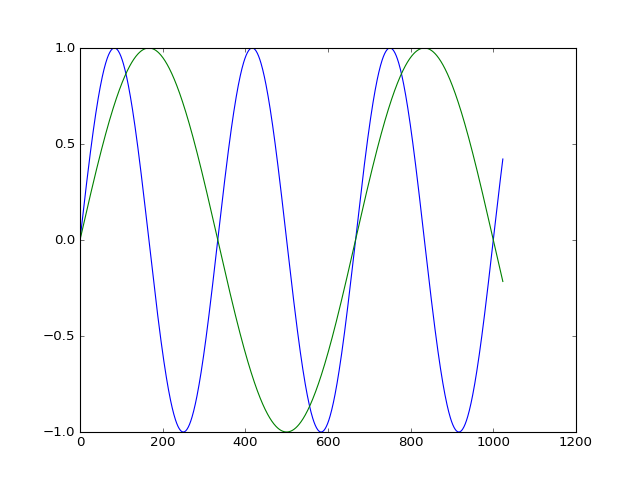

In [46]:
# original signals
plt.plot(s1[:1024])
plt.plot(s2[:1024])

<IPython.core.display.Javascript object>


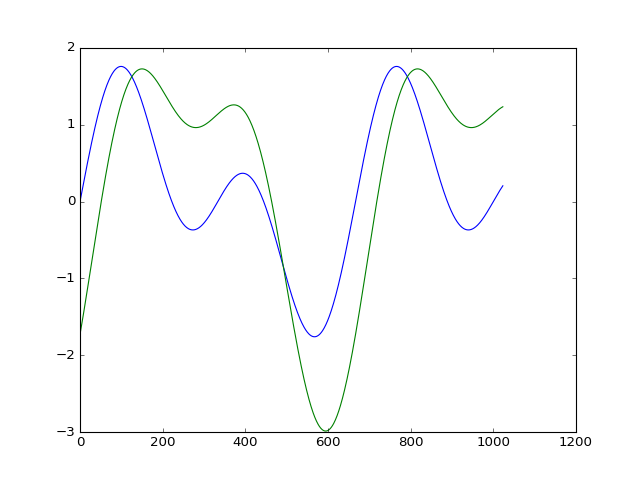

In [47]:
# mixtures
plt.plot(x1[:1024])
plt.plot(x2[:1024])

<IPython.core.display.Javascript object>


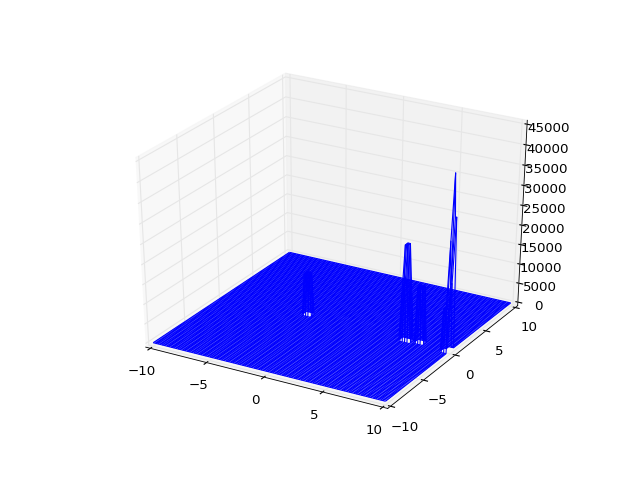

In [48]:
s1_rec, s2_rec = duet_ica(x1, x2, 1024, 512, 1024,
                          peakdelta = np.array([12, 44]),
                          peakalpha = np.array([0, 1.4]))

<IPython.core.display.Javascript object>


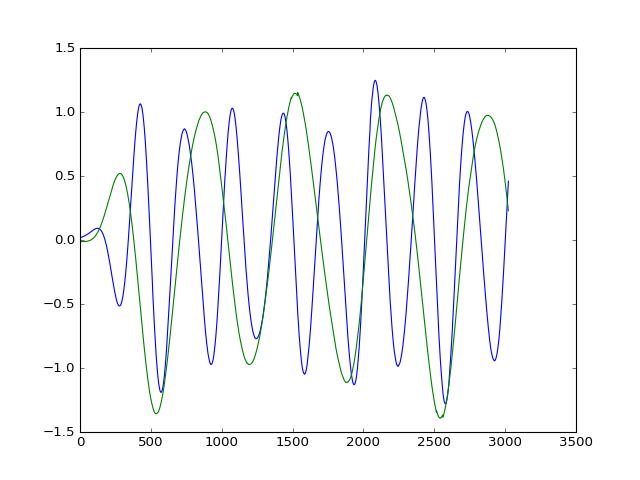

In [53]:
# mixtures
plt.plot(s1_rec[:3024])
plt.plot(s2_rec[:3024])

<IPython.core.display.Javascript object>


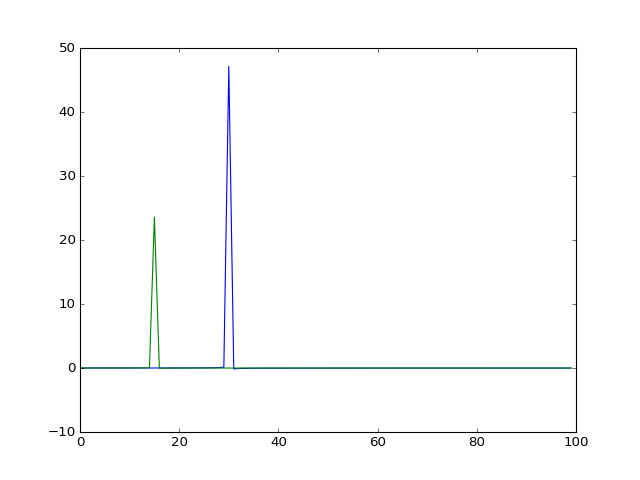

/home/mpavlov/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [50]:
plt.plot(fft(s1)[:100])
plt.plot(fft(s2)[:100])

<IPython.core.display.Javascript object>


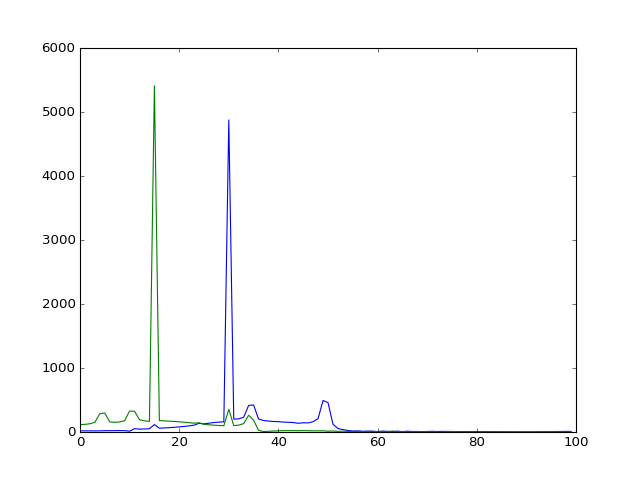

In [54]:
plt.plot(np.absolute(fft(s1_rec)[:100]))
plt.plot(np.absolute(fft(s2_rec)[:100]))